# Build a classification decision tree

We will illustrate how decision tree fit data with a simple classification
problem using the penguins dataset.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

In [1]:
import pandas as pd

penguins = pd.read_csv("../datasets/penguins_classification.csv")
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

Besides, we split the data into two subsets to investigate how trees will
predict values based on an out-of-samples dataset.

In [2]:
from sklearn.model_selection import train_test_split

data, target = penguins[culmen_columns], penguins[target_column]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)


In a previous notebook, we learnt that a linear classifier will define a
linear separation to split classes using a linear combination of the input
features. In our 2-dimensional space, it means that a linear classifier will
define some oblique lines that best separate our classes. We define a
function below that, given a set of data points and a classifier, will plot
the decision boundaries learnt by the classifier.

Thus, for a linear classifier, we will obtain the following decision
boundaries. These boundaries lines indicate where the model changes its
prediction from one class to another.

In [3]:
from sklearn.linear_model import LogisticRegression

linear_model = LogisticRegression()
linear_model.fit(data_train, target_train)

LogisticRegression()

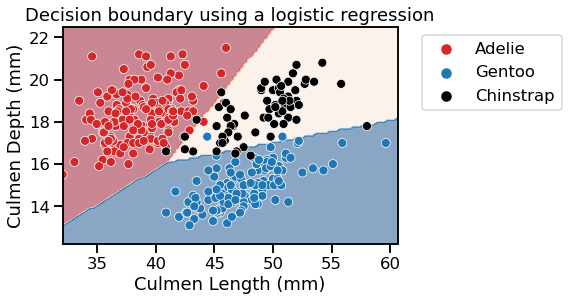

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

from helpers.plotting import DecisionBoundaryDisplay

# create a palette to be used in the scatterplot
palette = ["tab:red", "tab:blue", "black"]

DecisionBoundaryDisplay.from_estimator(
    linear_model, data_train, response_method="predict", cmap="RdBu", alpha=0.5
)
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
# put the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Decision boundary using a logistic regression")

We see that the lines are a combination of the input features since they are
not perpendicular a specific axis. Indeed, this is due to the model
parametrization that we saw in the previous notebook, controlled by the
model's weights and intercept.

Besides, it seems that the linear model would be a good candidate for
such problem as it gives good accuracy.

In [5]:
linear_model.fit(data_train, target_train)
test_score = linear_model.score(data_test, target_test)
print(f"Accuracy of the LogisticRegression: {test_score:.2f}")

Accuracy of the LogisticRegression: 0.98


Unlike linear models, decision trees are non-parametric models: they are not
controlled by a mathematical decision function and do not have weights or
intercept to be optimized.

Indeed, decision trees will partition the space by considering a single
feature at a time. Let's illustrate this behaviour by having a decision
tree make a single split to partition the feature space.

In [6]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=1)
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=1)

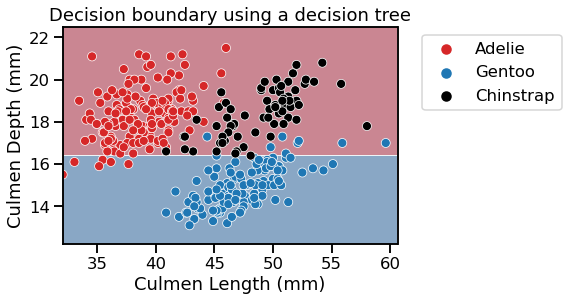

In [7]:
DecisionBoundaryDisplay.from_estimator(
    tree, data_train, response_method="predict", cmap="RdBu", alpha=0.5
)
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Decision boundary using a decision tree")

The partitions found by the algorithm separates the data along the axis
"Culmen Depth", discarding the feature "Culmen Length". Thus, it highlights
that a decision tree does not use a combination of feature when making a
split. We can look more in depth at the tree structure.

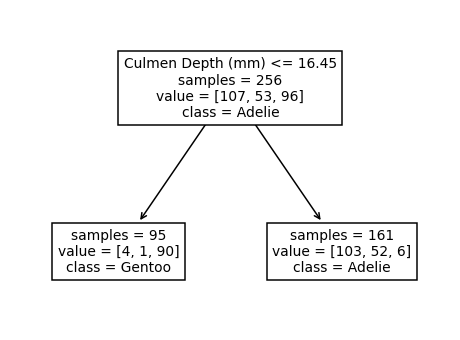

In [8]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(tree, feature_names=culmen_columns,
              class_names=tree.classes_, impurity=False, ax=ax)

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p class="last">We are using the function <tt class="docutils literal">fig, ax = <span class="pre">plt.subplots(figsize=(8,</span> 6))</tt> to create
a figure and an axis with a specific size. Then, we can pass the axis to the
<tt class="docutils literal">sklearn.tree.plot_tree</tt> function such that the drawing happens in this axis.</p>
</div>

We see that the split was done the culmen depth feature. The original
dataset was subdivided into 2 sets based on the culmen depth
(inferior or superior to 16.45 mm).

This partition of the dataset minimizes the class diversities in each
sub-partitions. This measure is also known as a **criterion**,
and is a settable parameter.

If we look more closely at the partition, we see that the sample superior to
16.45 belongs mainly to the Adelie class. Looking at the values, we indeed
observe 103 Adelie individuals in this space. We also count 52 Chinstrap
samples and 6 Gentoo samples. We can make similar interpretation for the
partition defined by a threshold inferior to 16.45mm. In this case, the most
represented class is the Gentoo species.

Let's see how our tree would work as a predictor. Let's start to see the
class predicted when the culmen depth is inferior to the threshold.

In [9]:
sample_1 = pd.DataFrame(
    {"Culmen Length (mm)": [0], "Culmen Depth (mm)": [15]}
)
tree.predict(sample_1)

array(['Gentoo'], dtype=object)

The class predicted is the Gentoo. We can now check if we pass a culmen
depth superior to the threshold.

In [10]:
sample_2 = pd.DataFrame(
    {"Culmen Length (mm)": [0], "Culmen Depth (mm)": [17]}
)
tree.predict(sample_2)

array(['Adelie'], dtype=object)

In this case, the tree predicts the Adelie specie.

Thus, we can conclude that a decision tree classifier will predict the most
represented class within a partition.

During the training, we have a count of samples in each partition, we can
also compute the probability of belonging to a specific class within this
partition.

In [11]:
y_pred_proba = tree.predict_proba(sample_2)
y_proba_class_0 = pd.Series(y_pred_proba[0], index=tree.classes_)

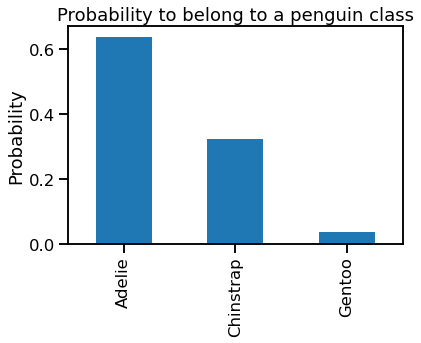

In [12]:
y_proba_class_0.plot.bar()
plt.ylabel("Probability")
_ = plt.title("Probability to belong to a penguin class")

We will manually compute the different probability directly from the tree
structure.

In [13]:
adelie_proba = 103 / 161
chinstrap_proba = 52 / 161
gentoo_proba = 6 / 161
print(
    f"Probabilities for the different classes:\n"
    f"Adelie: {adelie_proba:.3f}\n"
    f"Chinstrap: {chinstrap_proba:.3f}\n"
    f"Gentoo: {gentoo_proba:.3f}\n"
)

Probabilities for the different classes:
Adelie: 0.640
Chinstrap: 0.323
Gentoo: 0.037



It is also important to note that the culmen length has been disregarded for
the moment. It means that whatever the value given, it will not be used
during the prediction.

In [14]:
sample_3 = pd.DataFrame(
    {"Culmen Length (mm)": [10_000], "Culmen Depth (mm)": [17]}
)
tree.predict_proba(sample_3)

array([[0.63975155, 0.32298137, 0.03726708]])

Going back to our classification problem, the split found with a maximum
depth of 1 is not powerful enough to separate the three species and the model
accuracy is low when compared to the linear model.

In [15]:
tree.fit(data_train, target_train)
test_score = tree.score(data_test, target_test)
print(f"Accuracy of the DecisionTreeClassifier: {test_score:.2f}")

Accuracy of the DecisionTreeClassifier: 0.78


Indeed, it is not a surprise. We saw earlier that a single feature will not
be able to separate all three species. However, from the previous analysis we
saw that by using both features we should be able to get fairly good results.

In the next exercise, you will increase the size of the tree depth. You will
get intuitions on how the space partitioning is repeated over time.